In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import time
from torch.autograd import Variable

In [2]:
rgb_files = os.listdir('set-lipstick-original/720p')
rgb_files = [os.path.join('set-lipstick-original/720p', path) for path in rgb_files]
rgb_files[:5]

['set-lipstick-original/720p\\image00000001.jpg',
 'set-lipstick-original/720p\\image00000002.jpg',
 'set-lipstick-original/720p\\image00000003.jpg',
 'set-lipstick-original/720p\\image00000004.jpg',
 'set-lipstick-original/720p\\image00000005.jpg']

In [3]:
mask_files = os.listdir('set-lipstick-original/mask')
mask_files = [os.path.join('set-lipstick-original/mask', path) for path in mask_files]
mask_files[:5]

['set-lipstick-original/mask\\mask00000001.png',
 'set-lipstick-original/mask\\mask00000002.png',
 'set-lipstick-original/mask\\mask00000003.png',
 'set-lipstick-original/mask\\mask00000004.png',
 'set-lipstick-original/mask\\mask00000005.png']

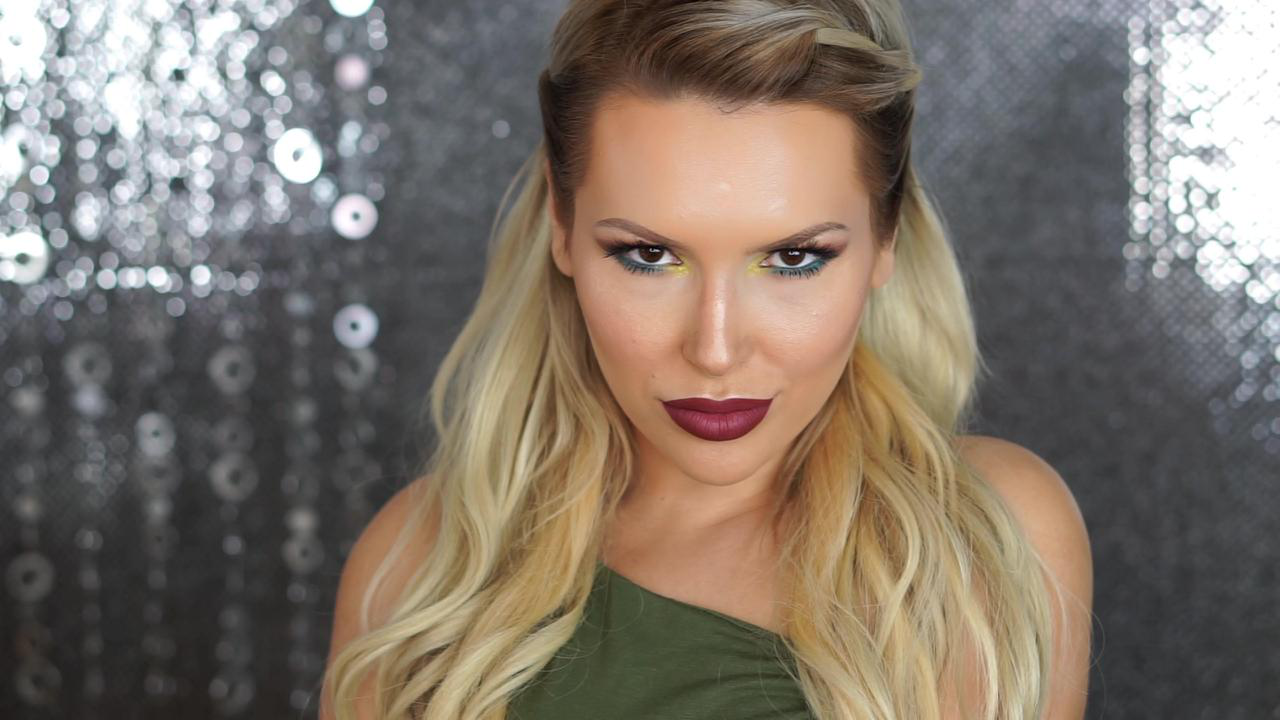

In [4]:
image = Image.open(rgb_files[0])
image

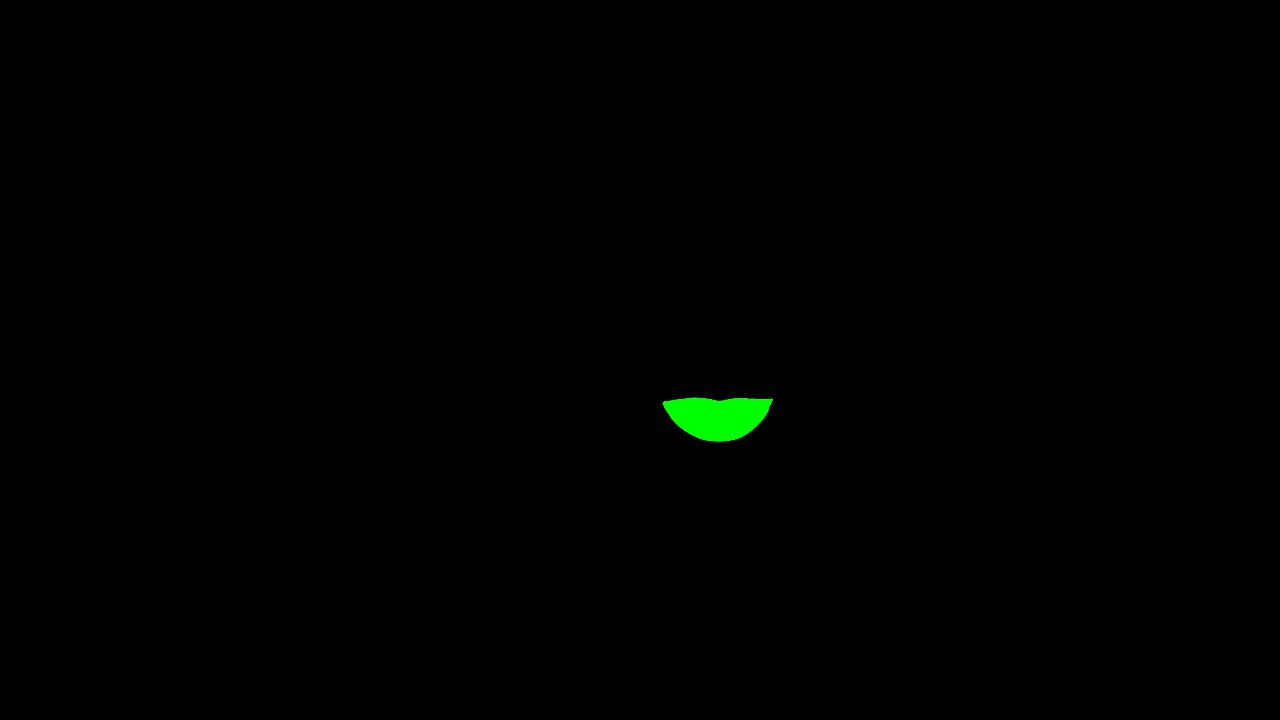

In [5]:
image = Image.open(mask_files[0])
image

На всякий случай отсортируем

In [6]:
rgb_files.sort()

In [7]:
mask_files.sort()

In [8]:
rgb_files[:5]

['set-lipstick-original/720p\\image00000001.jpg',
 'set-lipstick-original/720p\\image00000002.jpg',
 'set-lipstick-original/720p\\image00000003.jpg',
 'set-lipstick-original/720p\\image00000004.jpg',
 'set-lipstick-original/720p\\image00000005.jpg']

In [9]:
mask_files[:5]

['set-lipstick-original/mask\\mask00000001.png',
 'set-lipstick-original/mask\\mask00000002.png',
 'set-lipstick-original/mask\\mask00000003.png',
 'set-lipstick-original/mask\\mask00000004.png',
 'set-lipstick-original/mask\\mask00000005.png']

In [10]:
len(rgb_files)

28594

In [11]:
len(mask_files)

28540

In [12]:
# Так, замечательно, блин. Они еще и не совпадают по количеству....
# Придется как-то выкручиваться
corrected_rgb_files = []
corrected_mask_files = []
rgb_iter = iter(rgb_files)
mask_iter = iter(mask_files)
for mask_file in mask_iter:
    msk = os.path.splitext(os.path.basename(mask_file))[0][4:]
    while 1:
        rgb_file = next(rgb_iter)
        rgb = os.path.splitext(os.path.basename(rgb_file))[0][5:]
        if rgb == msk:
            corrected_rgb_files.append(rgb_file)
            corrected_mask_files.append(mask_file)
            break

In [13]:
len(corrected_rgb_files)

28540

In [14]:
len(corrected_mask_files)

28540

In [15]:
# Еще более тщательная проверка...
for a, b in zip(corrected_rgb_files, corrected_mask_files):
    rgb = os.path.splitext(os.path.basename(a))[0][5:]
    msk = os.path.splitext(os.path.basename(b))[0][4:]
    if rgb != msk:
        print(f'{rgb} - {msk}')

Пусто, значит по индексам они теперь совпадают. Надеюсь и по содержанию там все правильно

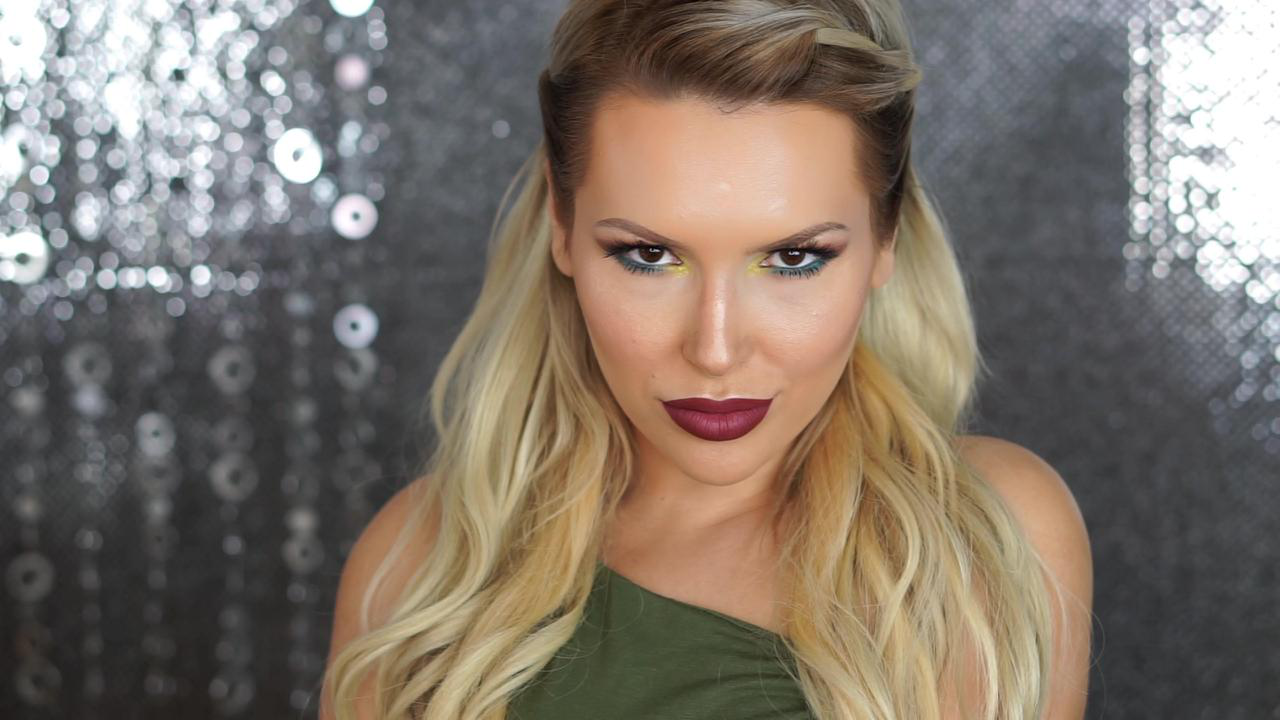

In [16]:
image = Image.open(corrected_rgb_files[0])
image

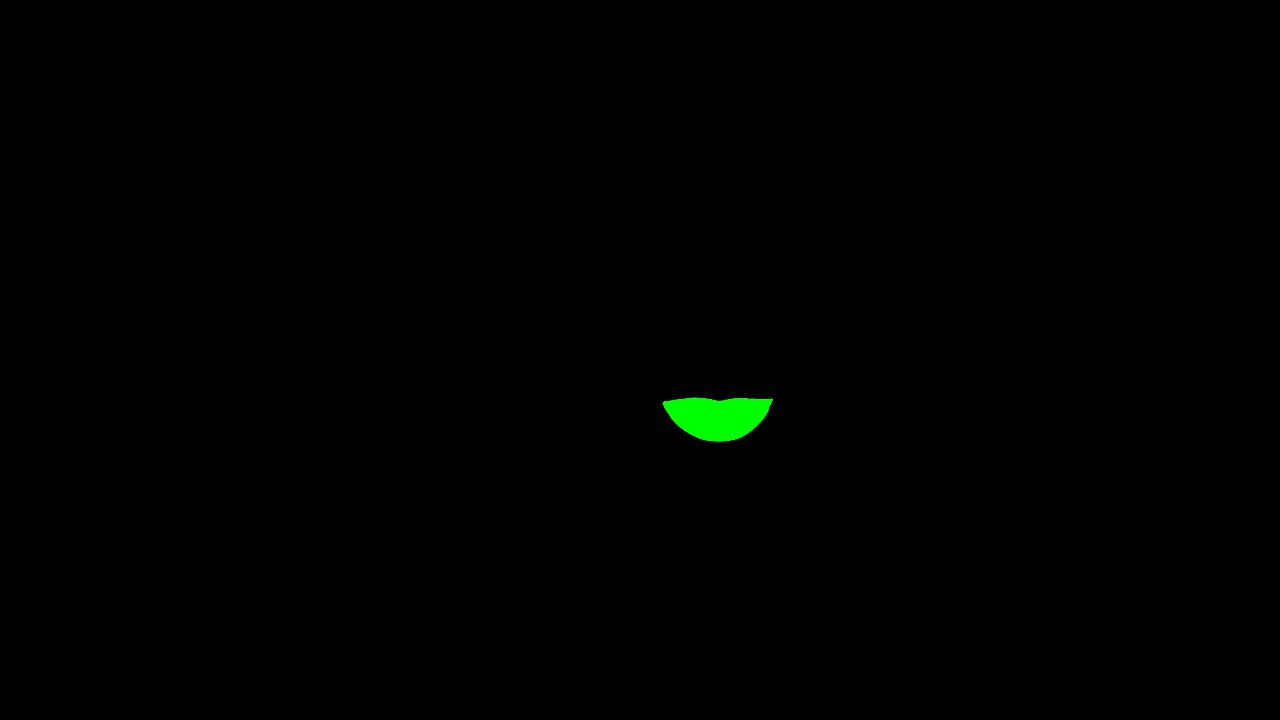

In [17]:
image = Image.open(corrected_mask_files[0])
image

Теперь видимо норм

In [18]:
# Интересно, что там за значения в лэйблах
label = np.array(image)
label.shape

(720, 1280, 3)

In [19]:
label.max()

255

In [20]:
# Так - судя по тому, что они зеленые - видимо нам придется делать бинарный лейбл из зеленого канала rgb картинки
label = label[:, :, [1]]/255.0
label = label.reshape((label.shape[0], label.shape[1]))
label.shape

(720, 1280)

In [21]:
label.max()

1.0

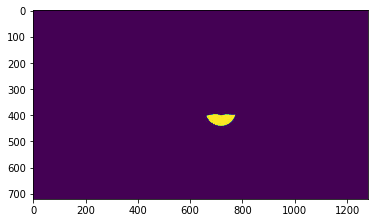

In [22]:
plt.imshow(label)

In [24]:
# Норм
# Что еще нам нужно будет делать - это уменьшить картинки (для облегчения процесса тренировки) это мы в датасете реализуем

In [25]:
class LipsDataset(Dataset):
    def __init__(self, rgb_files, label_files, resize_to=(256, )):
        self.rgb_files = rgb_files
        self.label_files = label_files
        self.resize = resize_to

    def __len__(self):
        return len(self.rgb_files)
    
    def __getitem__(self, idx):
        rgb = Image.open(self.rgb_files[idx])
        mask = Image.open(self.label_files[idx])
        if self.resize:
            new_width = self.resize[0]
            new_height = rgb.size[1] * (new_width / rgb.size[0])
            if len(self.resize) > 1:
                new_height = self.resize[1]
                
            new_width, new_height = int(new_width), int(new_height)
                
            rgb = rgb.resize((new_width, new_height))
            mask = mask.resize((new_width, new_height))
        
        rgb_data = np.array(rgb)
        rgb_data = torch.as_tensor(rgb_data)/255.0
        rgb_data = rgb_data.permute(2,0,1)
        
        label = np.array(mask)
        label = label[:, :, [1]]
        label = label.reshape((label.shape[0], label.shape[1]))
        label = torch.as_tensor(label)/255.0
            
        return (rgb_data, label) 

In [26]:
dataset = LipsDataset(corrected_rgb_files[:330], corrected_mask_files[:330], resize_to=(256, 256))
dataset.__len__()

330

In [27]:
# Делим на трейн-тест, настраиваем батч-лоадеры
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [320,10])
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [28]:
i = iter(train_dataset)

In [29]:
image, label = i.__next__()

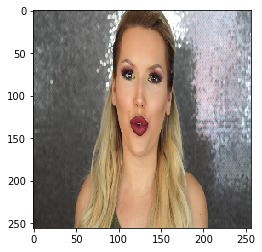

In [30]:
plt.imshow(image.permute((1,2,0)))

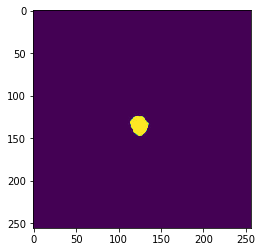

In [31]:
plt.imshow(label)

In [32]:
# Ок. Переходим к сети

In [ ]:
# Попробуем для начала ванильный U-net с вебинара ))

In [33]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        self.softmax = nn.Softmax()
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]
        output = self.softmax(output)

        return output

In [34]:
learning_rate = 0.0005
epochs = 25
u_model = UNet(num_classes=2)
optimizer = torch.optim.Adam(u_model.parameters())

In [35]:
def dice_loss(output, target, weights=None, ignore_index=None):
    """
    output : NxCxHxW Variable
    target :  NxHxW LongTensor
    weights : C FloatTensor
    ignore_index : int index to ignore from loss
    """
    eps = 0.0001

    output = output.float().exp()
    target = target.type(torch.int64)
    encoded_target = output.detach() * 0
    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone()
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else:
        encoded_target.scatter_(1, target.unsqueeze(1), 1)

    if weights is None:
        weights = 1

    intersection = output * encoded_target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + encoded_target

    if ignore_index is not None:
        denominator[mask] = 0
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = weights * (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

In [36]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =(2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        #print(score.sum())
        score =1 - score.sum() / num
        return score
    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target

In [37]:
criterion=SoftDiceLoss()

In [38]:
torch.set_num_threads(16)

In [39]:
# Полезная функция для детектирования аномалий в процессе обучения
#torch.autograd.set_detect_anomaly(True)

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    time1 = time.time()
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        outputs = u_model(data)


        
        #loss = nn.CrossEntropyLoss(outputs,labels)# - torch.log(SoftDiceLoss(outputs, labels))
        loss = dice_loss(outputs, labels)
        
        print(f'batch_idx: {batch_idx}, loss: {loss}')
        
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        if batch_idx%200==0:
            print(f'batch index : {batch_idx} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    time2 = time.time()
    print(f'Spend time for 1 epoch: {time2-time1} sec')
    
    epoch_losses.append(epoch_loss)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


batch_idx: 0, loss: 0.37397104501724243


C:\Users\Asus\Anaconda3\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


batch index : 0 | loss : 0.37397104501724243
batch_idx: 1, loss: 0.3488318622112274
batch_idx: 2, loss: 0.3334110379219055
batch_idx: 3, loss: 0.3168817460536957
batch_idx: 4, loss: 0.3076290786266327
batch_idx: 5, loss: 0.30006009340286255
batch_idx: 6, loss: 0.2928571403026581
batch_idx: 7, loss: 0.29181593656539917
batch_idx: 8, loss: 0.28742608428001404
batch_idx: 9, loss: 0.28381404280662537
Epoch 1, loss:  0.31366980671882627
Spend time for 1 epoch: 563.5532467365265 sec
batch_idx: 0, loss: 0.2845629155635834
batch index : 0 | loss : 0.2845629155635834
batch_idx: 1, loss: 0.2801957428455353
batch_idx: 2, loss: 0.2771489918231964
batch_idx: 3, loss: 0.27665337920188904
batch_idx: 4, loss: 0.277214378118515
batch_idx: 5, loss: 0.2793846130371094
batch_idx: 6, loss: 0.2672678530216217
batch_idx: 7, loss: 0.2753313481807709
batch_idx: 8, loss: 0.274952232837677
batch_idx: 9, loss: 0.2749662399291992
Epoch 2, loss:  0.27676776945590975
Spend time for 1 epoch: 555.6065723896027 sec
bat

Epoch 16, loss:  0.255054971575737
Spend time for 1 epoch: 553.0299894809723 sec
batch_idx: 0, loss: 0.25466474890708923
batch index : 0 | loss : 0.25466474890708923
batch_idx: 1, loss: 0.2530834972858429
batch_idx: 2, loss: 0.25297319889068604
batch_idx: 3, loss: 0.2551722824573517
batch_idx: 4, loss: 0.2533460855484009
batch_idx: 5, loss: 0.25394538044929504
batch_idx: 6, loss: 0.25662609934806824
batch_idx: 7, loss: 0.25701501965522766
batch_idx: 8, loss: 0.254204124212265
batch_idx: 9, loss: 0.25561004877090454
Epoch 17, loss:  0.2546640485525131
Spend time for 1 epoch: 552.050225019455 sec
batch_idx: 0, loss: 0.2523179054260254
batch index : 0 | loss : 0.2523179054260254
batch_idx: 1, loss: 0.25417831540107727
batch_idx: 2, loss: 0.25501954555511475
batch_idx: 3, loss: 0.25692132115364075
batch_idx: 4, loss: 0.2558380961418152
batch_idx: 5, loss: 0.2545265853404999
batch_idx: 6, loss: 0.2527059316635132
batch_idx: 7, loss: 0.25487035512924194
batch_idx: 8, loss: 0.2552591264247894

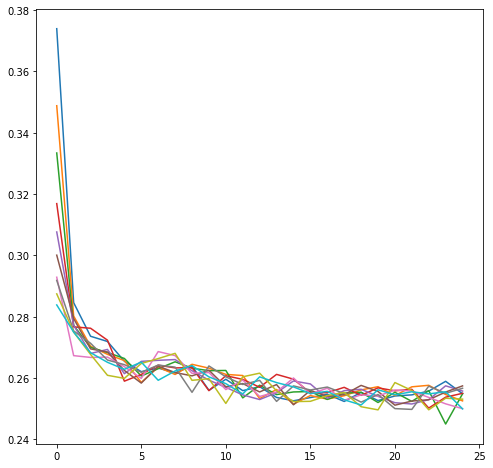

In [40]:
plt.figure(figsize=(8,8))
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.draw()

In [41]:
i = iter(test_loader)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


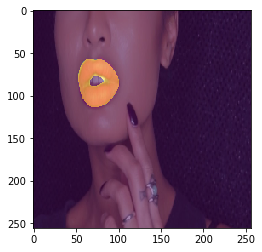

In [42]:
image, label = i.__next__()
pred_label = u_model(image)
plt.imshow(image[-1,].permute((1,2,0)))
plt.imshow(pred_label.detach()[-1,-1,], alpha=0.5)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


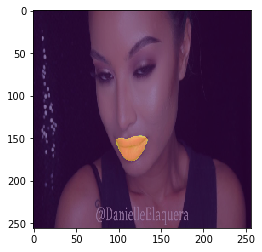

In [43]:
image, label = i.__next__()
pred_label = u_model(image)
plt.imshow(image[-1,].permute((1,2,0)))
plt.imshow(pred_label.detach()[-1,-1,], alpha=0.5)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


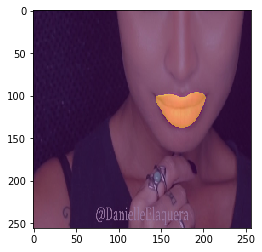

In [44]:
image, label = i.__next__()
pred_label = u_model(image)
plt.imshow(image[-1,].permute((1,2,0)))
plt.imshow(pred_label.detach()[-1,-1,], alpha=0.5)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


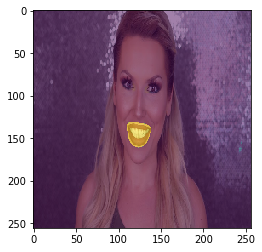

In [45]:
image, label = i.__next__()
pred_label = u_model(image)
plt.imshow(image[-1,].permute((1,2,0)))
plt.imshow(pred_label.detach()[-1,-1,], alpha=0.5)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


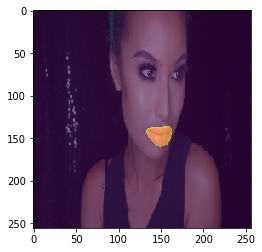

In [46]:
image, label = i.__next__()
pred_label = u_model(image)
plt.imshow(image[-1,].permute((1,2,0)))
plt.imshow(pred_label.detach()[-1,-1,], alpha=0.5)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


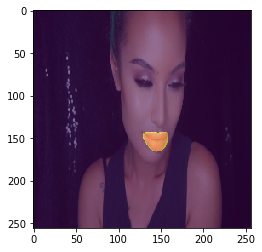

In [47]:
image, label = i.__next__()
pred_label = u_model(image)
plt.imshow(image[-1,].permute((1,2,0)))
plt.imshow(pred_label.detach()[-1,-1,], alpha=0.5)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


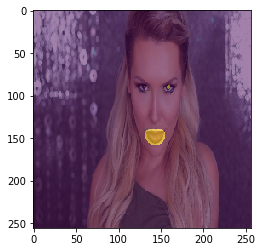

In [48]:
image, label = i.__next__()
pred_label = u_model(image)
plt.imshow(image[-1,].permute((1,2,0)))
plt.imshow(pred_label.detach()[-1,-1,], alpha=0.5)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


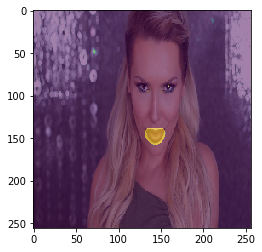

In [49]:
image, label = i.__next__()
pred_label = u_model(image)
plt.imshow(image[-1,].permute((1,2,0)))
plt.imshow(pred_label.detach()[-1,-1,], alpha=0.5)

### Ну слегка как-то научили..